<a href="https://colab.research.google.com/github/ganyiwatakunda/Image-Captioning-/blob/main/imagecaption_generator_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the dataset


In [1]:
#import the libraries
import tensorflow as tf
import keras
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter
warnings.filterwarnings("ignore")


In [2]:
!pip install kaggle


In [3]:
from google.colab import files

In [4]:
#loading the kaggle.json file that has the key for us to download the dataset diectly from kaggle
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"takundaganyiwa","key":"05577c39843464b2a990f9c54f7119c1"}'}

In [5]:
#creating a directory to load the dataset
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


rm: cannot remove '/root/.kaggle': No such file or directory


In [6]:
!kaggle datasets download shadabhussain/flickr8k --unzip


100% 2.13G/2.13G [00:24<00:00, 98.5MB/s]
100% 2.13G/2.13G [00:24<00:00, 94.7MB/s]


In [7]:
## The location of the Flickr8K images
images ='/content/Flickr_Data/Flickr_Data/Images'
## The location of the file that contains the captions of the images
captions = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
#to know the number of images in the folder
img = os.listdir(images)
print("The number of img flies in Flicker8k dataset is: {}".format(len(img)))

The number of img flies in Flicker8k dataset is: 8091


In [8]:
## read in the Flickr caption data
file = open(captions,'r')
text = file.read()
file.close()


caption_txt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    caption_txt.append(w + [col[1].lower()])

#Load the caption data and save it into a panda dataframe df_caption_txt.
df_caption_txt = pd.DataFrame(caption_txt,columns=["filename","index","caption"])

#check for the filenames of the caption that have unique data
unique_filenames = np.unique(df_caption_txt.filename.values)
print("The number of unique filenames : {}".format(len(unique_filenames)))
print("The number of captions for each image is ")

# Counting number of captions for each image using counter
Counter(Counter(df_caption_txt.filename.values).values())

The number of unique filenames : 8092
The number of captions for each image is 


Counter({5: 8092})

In [9]:
#show the first 5 captions of one image
df_caption_txt.head()


,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...


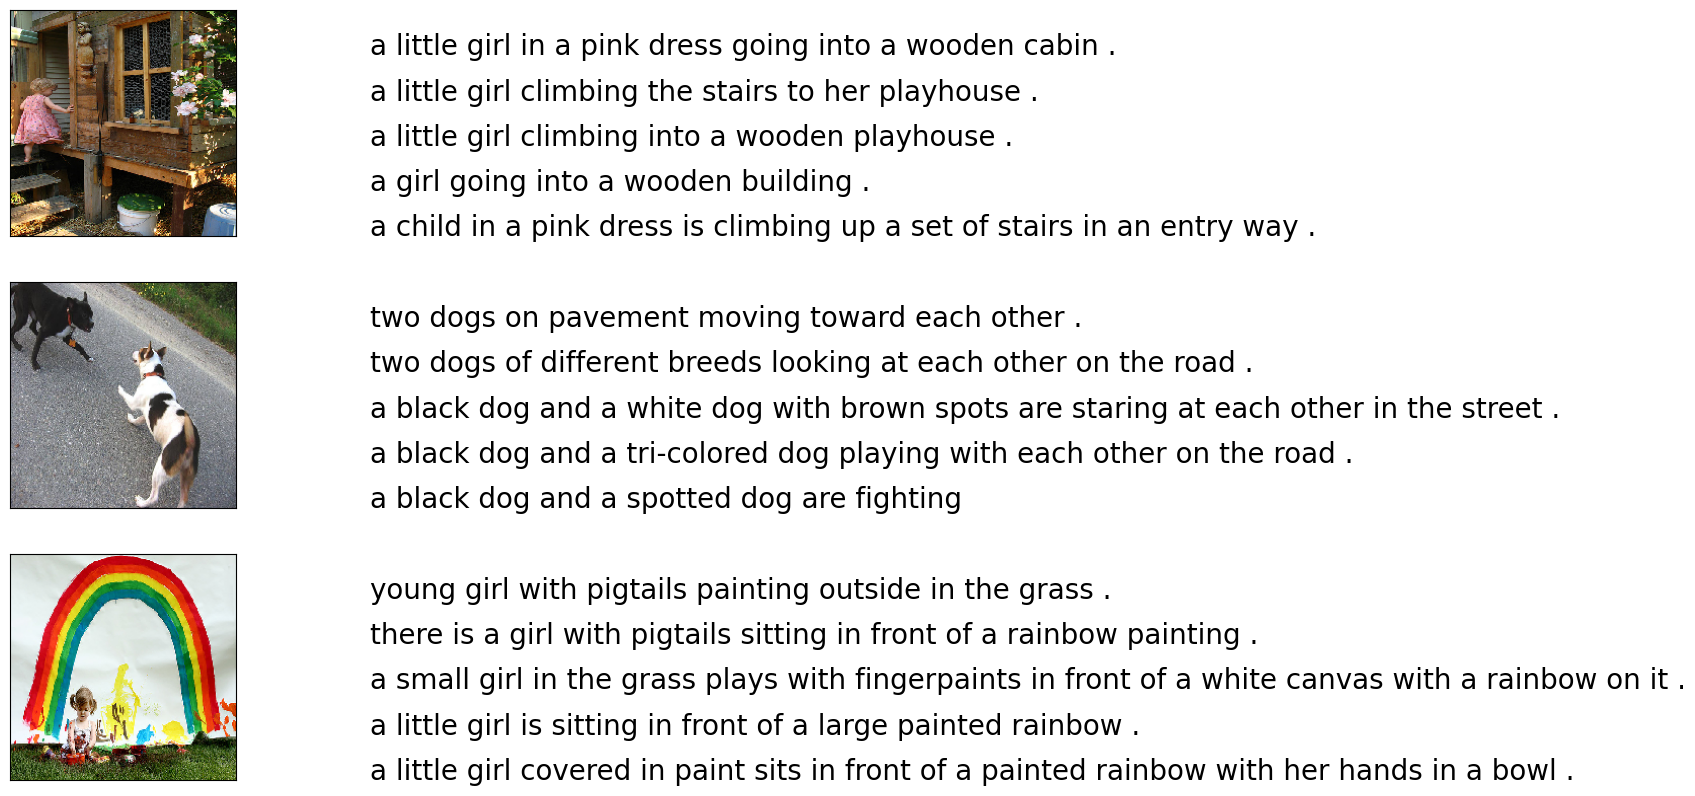

In [10]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Displaying 3 images from the dataset so that we can see the 5 captions it is generating
npic = 3
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,10))
for jpgfnm in unique_filenames[:npic]:
    filename = images + '/' + jpgfnm
    captions = list(df_caption_txt["caption"].loc[df_caption_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
#visualising the image
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

# Preparing the data in the captions text file


In [11]:
#creating a dataframe to visualise how the vocabulary is didtributed
def df_caption_word(df_caption_txt):
    vocab = []
    for txt in df_caption_txt.caption.values:
        vocab.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocab)))
    ct = Counter(vocab)
    caption_vocab = pd.DataFrame(list(ct.items()), columns=['word', 'count'])
    caption_vocab.sort_values(by='count', ascending=False, inplace=True)
    caption_vocab = caption_vocab.reset_index()[["word","count"]]
    return(caption_vocab)
caption_vocab = df_caption_word(df_caption_txt)
#viewing the first 5 word and and counts of the top most appearing words
caption_vocab.head()

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975
3,the,18419
4,on,10744


#Cleaning all the data in the captions file

In [12]:
import pandas as pd


In [13]:
df_caption_txt['caption'] = df_caption_txt['caption'].str.replace(',', '')
df_caption_txt['caption']= df_caption_txt['caption'].str.strip()
df_caption_txt['caption']= df_caption_txt['caption'].str.lower()


In [14]:
df_caption_txt['caption']=df_caption_txt['caption'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')


In [15]:
cleaned_captions =df_caption_txt


In [16]:
#adding start and end sequence token in each and every token
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'begin ' + txt + ' end'
        caps.append(txt)
    return(caps)
df_caption_txt0 = copy(df_caption_txt)
df_caption_txt["caption"] = add_start_end_seq_token(df_caption_txt["caption"])
df_caption_txt.head(5)
del df_caption_txt

In [17]:
#using the pretrained model of vgg model which takes input image of size (224, 224, 3).
modelvgg = tf.keras.applications.VGG16(include_top=True, weights=None)
## load the locally saved weights
modelvgg.load_weights("/content/model_weights.h5", skip_mismatch=True, by_name=True)
modelvgg.layers.pop()
#we just need it for extracting features, so will remove the last layer from the network.
modelvgg = tf.keras.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
modelvgg.save('feature_extraction_model.h1')

In [19]:
#transforming the images into features using the model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

pictures = OrderedDict()
pictures.update()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(img),npix,npix,3))
for i,name in enumerate(img):
    # load an image from file
    filename = '/content/Flickr_Data/Flickr_Data/Images'+ '/'+ name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)

    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    pictures[name] = y_pred.flatten()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 581ms/step


In [20]:
#viewing the features of any image in the images folder
pictures['1002674143_1b742ab4b8.jpg']


array([0.1778268 , 1.2945424 , 0.        , ..., 0.00483394, 0.3201345 ,
       0.6476903 ], dtype=float32)

In [21]:
len(pictures)


8091

In [22]:
#mapping the caption and image data
dpictures, keepindex = [],[]
df_caption_txt0 = df_caption_txt0.loc[df_caption_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_caption_txt0.filename):
    if fnm in pictures.keys():
        dpictures.append(pictures[fnm])
        keepindex.append(i)

fnames = df_caption_txt0["filename"].iloc[keepindex].values
dcaptions = df_caption_txt0["caption"].iloc[keepindex].values
dpictures = np.array(dpictures)

In [23]:
# 4096 features for all 8091 images

dpictures.shape

(8091, 4096)

In [24]:
# List of caption for each image in the first 5

dcaptions[:5]

array([' child in pink dress is climbing up set of stairs in an entry way .',
       ' black dog and spotted dog are fighting',
       ' little girl covered in paint sits in front of painted rainbow with her hands in bowl .',
       ' man lays on bench while his dog sits by him .',
       ' man in an orange hat starring at something .'], dtype=object)

In [25]:
#Changing character vector to integer vector/tokens
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("The vocabulary size is{}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)

The vocabulary size is4407


In [26]:
import pickle
# saving the tokenizer.pkl file for use iin streamlit
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# We will split the dataset in ratio 6:2:2 (train:valid:test)
#Spliting the dataset in training and testing
prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest],
           dtexts[Ntest:Ntest+Nval],
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dpictures,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [28]:
# We need maxlen because keras layer takes input of all the sequences of same length.
# Hence to do the padding we need maximum length in caption

maxlen = np.max([len(text) for text in dtexts])

In [29]:
#performing padding
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dpictures):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dpictures))
    Xtext, Xpicture, ytext = [],[],[]
    for text,picture in zip(dtexts,dpictures):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Xpicture.append(picture)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Xpicture = np.array(Xpicture)
    ytext  = np.array(ytext)
    print(" Xtext shape{}".format(Xtext.shape))
    print(" Xpicture shape{}".format(Xpicture.shape) )
    print(" ytext shape{}".format(ytext.shape)   )
    return(Xtext,Xpicture,ytext)


Xtext_train, Xpicture_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Xpicture_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Xpicture_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 Xtext shape(40103, 28)
 Xpicture shape(40103, 4096)
 ytext shape(40103, 4407)
# captions/images = 1618
 Xtext shape(13165, 28)
 Xpicture shape(13165, 4096)
 ytext shape(13165, 4407)


In [30]:
Xpicture_train.shape

(40103, 4096)

In [31]:
ytext_train.shape


(40103, 4407)

In [32]:
Xpicture_train.shape[1]


4096

In [33]:
from tensorflow.keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Xpicture_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="FeatureOfImage")(input_image)
#model for the encoder that has sequence ,embedding layer , and lstm layer
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="FeatureofCaption")(ftxt)

## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
encoderdecodermodel = tf.keras.Model(inputs=[input_image, input_txt],outputs=output)

encoderdecodermodel.compile(loss='categorical_crossentropy', optimizer='adam')

print(encoderdecodermodel.summary())

4407
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 28, 64)               282048    ['input_3[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 FeatureofCaption (LSTM)     (None, 256)                  328704    ['embedding[0][0]']           
                                                                                       

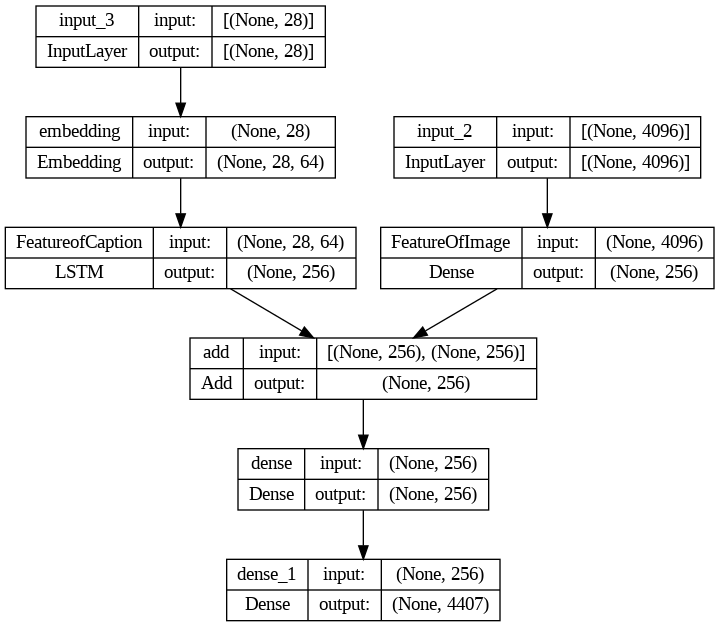

In [37]:
#tf.keras.utils.plot_encoderdecodermodel()
from keras.utils import plot_model
plot_model(encoderdecodermodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
encoderdecodermodel.save('encoderdecodermodel.h5')

In [34]:
# fit model
hist = encoderdecodermodel.fit([Xpicture_train, Xtext_train], ytext_train,
                  epochs=6, verbose=2,
                  batch_size=64,
                  validation_data=([Xpicture_val, Xtext_val], ytext_val))



Epoch 1/6
627/627 - 146s - loss: 5.8394 - val_loss: 5.1923 - 146s/epoch - 233ms/step
Epoch 2/6
627/627 - 128s - loss: 4.8493 - val_loss: 4.8427 - 128s/epoch - 204ms/step
Epoch 3/6
627/627 - 131s - loss: 4.3697 - val_loss: 4.7200 - 131s/epoch - 208ms/step
Epoch 4/6
627/627 - 137s - loss: 4.0431 - val_loss: 4.7219 - 137s/epoch - 218ms/step
Epoch 5/6
627/627 - 136s - loss: 3.7830 - val_loss: 4.7723 - 136s/epoch - 217ms/step
Epoch 6/6
627/627 - 138s - loss: 3.5460 - val_loss: 4.9089 - 138s/epoch - 219ms/step


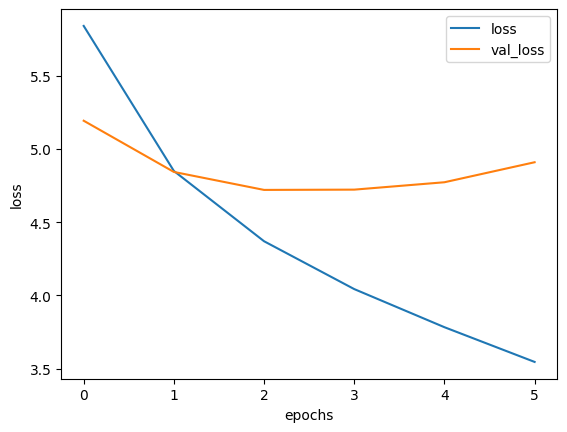

In [35]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()